In [ ]:
# imports
import math
import folium
import squarify
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from folium.plugins import HeatMap
from matplotlib.colors import Normalize
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

## I went about building this notebook to gain more experience with the analyzes of geospatial data, developing interactive maps, and due to a general interest in crime statistics

In [ ]:
# read and display head of data
crime = pd.read_csv('./Boston-Crime.csv')
crime.head()

In [ ]:
# display offense code descritption/group unique values
print('Amount of unique offense descriptions: ' + str(len(crime['OFFENSE_DESCRIPTION'].unique())))
print('Amount of unique offense code groups: ' + str(len(crime['OFFENSE_CODE_GROUP'].unique())))

Amount of unique offense descriptions:  283 </br>
Amount of unique offense code groups:  68   </br>

In [ ]:
# displaying na value sums for each colum
crime.isna().sum()

|          |  |
| ------------------- | ----------- |
| INCIDENT_NUMBER     |        0|
| OFFENSE_CODE        |       0|
| OFFENSE_CODE_GROUP  |    98736|
| OFFENSE_DESCRIPTION |        0|
| DISTRICT            |     2462|
| REPORTING_AREA      |        0|
| SHOOTING            |   425093|
| OCCURRED_ON_DATE    |        0|
| YEAR                |        0|
| MONTH               |        0|
| DAY_OF_WEEK         |        0|
| HOUR                |        0|
| UCR_PART            |    98846|
| STREET              |    21189|
| Lat                 |    29754|
| Long                |    29754|
| Location            |        0|
| Date                |        0 |
| dtype: int64        |           |

In [ ]:
# dropped crime without known location
map_data = crime.dropna(subset=['Lat', 'Long'])

# displaying na value sums for each colum to make sure Long and Lat are dropped
map_data.isna().sum()

|               |  |
| ------------------- | ----------- |
| INCIDENT_NUMBER           |  0    |
| OFFENSE_CODE             |   0|
| OFFENSE_CODE_GROUP      |96186|
| OFFENSE_DESCRIPTION      |   0|
| DISTRICT                | 1927|
| REPORTING_AREA         |     0|
| SHOOTING              | 397950|
| OCCURRED_ON_DATE            |0|
| YEAR                       | 0|
| MONTH                     |  0|
| DAY_OF_WEEK              |   0|
| HOUR                    |   0|
| UCR_PART                |96295|
| STREET                  |11111|
| Lat                      |   0|
| Long                    |    0|
| Location               |     0|
| Date                  |      0|
| dtype: int64       | |

## Mapping of crimes data and general analysis

In [ ]:
# creating folium map of boston
f = folium.Figure(width=700, height=400)
m = folium.Map(location=[42.32, -71.0589], titles='openstreetmap', zoom_start=10, max_zoom=15, min_zoom=10).add_to(f)

# adding and displaying heat map of crimes with latitude/longitude 
HeatMap(data=map_data[['Lat', 'Long']], radius=10).add_to(m)
m

**Gif of interactive map for github viewing** </br>


<img src='./images/m_1_gif.gif' style='width:600px;height:300px;'>


In [ ]:
# looking at column data types
crime.dtypes

|               |  |
| ------------------- | ----------- |
| INCIDENT_NUMBER     |    object |
|OFFENSE_CODE           |  int64|
|OFFENSE_CODE_GROUP     | object|
|OFFENSE_DESCRIPTION    | object|
|DISTRICT               | object|
|REPORTING_AREA         | object|
|SHOOTING               | object|
|OCCURRED_ON_DATE       | object|
|YEAR                   |  int64|
|MONTH                  |  int64|
|DAY_OF_WEEK           |  object|
|HOUR                 |    int64|
|UCR_PART            |    object|
|STREET             |     object|
|Lat               |     float64|
|Long             |      float64|
|Location        |        object|
|dtype: object| |

In [ ]:
# reading and plotting boston police district shape data 
police_districts = gpd.read_file('./geodata/police_districts.shp')
police_districts.plot()

<img src='./images/choropleth.png' style='width:700px;height:500px;'>

In [ ]:
# label reference points on map
police_districts['point'] = police_districts.representative_point()
labels = police_districts.copy()
labels.set_geometry('point', inplace = True)

# plot districts
ax = police_districts.plot(figsize = (12,8), edgecolor = 'black')

# put labels in districts
for x, y, label in zip(labels.geometry.x, labels.geometry.y, labels['DISTRICT']):
    plt.text(x, y, label, fontsize = 10, fontweight = 'bold')


plt.title('Crime Districts in Boston', fontsize = 20)

<img src='./images/choropleth_label.png' style='width:700px;height:500px;'>

In [ ]:
# getting rid of external district values
crime_districts = crime[crime['DISTRICT'] != 'External']
crime_districts = crime_districts['DISTRICT'].value_counts()

In [ ]:
# mapping and plotting district crime data
police_districts['crimes'] = police_districts.DISTRICT.map(crime_districts)
ax = police_districts.plot(column = police_districts.crimes, cmap = 'viridis', legend = True, edgecolor = 'black', figsize = (12,8))

# put labels in districts
for x, y, label in zip(labels.geometry.x, labels.geometry.y, labels['DISTRICT']):
    plt.text(x, y, label, fontsize = 10, fontweight = 'bold', c = 'white')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crimes per district in Boston', fontsize = 20)

<img src='./images/choropleth_crime.png' style='width:700px;height:500px;'>

### Most crimes seem to be concentrated around District B2

## General analysis

In [ ]:
# setting seaborn plot sizes
sns.set(rc={'figure.figsize':(12,8)})

# function for quicker heatmap creation
def heatmap_maker(data, index, columns, xlabel, ylabel, title):
    pivot = pd.pivot_table(data=data, index=index, columns=columns, values = 'INCIDENT_NUMBER', aggfunc = 'count')
    sns.heatmap(pivot, cmap = 'viridis')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize = 20)

In [ ]:
# heat map of districts vs months
heatmap_maker(data = crime, index = 'MONTH', columns = 'DISTRICT', 
                xlabel='Districts', ylabel='Months', title = 'Districts vs Months Heat Map')

<img src='./images/district_month_crime.png' style='width:700px;height:500px;'>

### Crime rates in most districts seem to peak from July to October so lets look into time series to see when yearly peaks of crime are

In [ ]:
# created datetime column from occured date
crime['OCCURRED_ON_DATE'] = pd.to_datetime(crime['OCCURRED_ON_DATE'])
crime['Date'] = crime['OCCURRED_ON_DATE'].dt.date
crime_date_df = crime['Date'].value_counts().to_frame()
crime_date_df.reset_index(inplace=True)
crime_date_df = crime_date_df.rename(columns = {'index':'Date', 'Date':'Count'})
crime_date_df = crime_date_df.sort_values(by='Date')

In [ ]:
# creating axis with datetime and then plot time series
fig, ax = plt.subplots(figsize=(12, 8))
half_year_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(half_year_locator) 
year_month_formatter = mdates.DateFormatter('%Y-%m') 
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(crime_date_df['Date'], crime_date_df['Count'])

# rotate/align x axis and label axes
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Crimes Commited per Day')
plt.title('Timeseries of Crimes a Day from 2015-2020', fontsize=20)

<img src='./images/timeseries_crime.png' style='width:900px;height:500px;'>

### Crime rates seem to be mostly cyclical and peark from July to October so we will explore this more
### Two things interesting to note is the drop in rate at the start of the pandemic and the drastic spike toward the end of the dataset

In [37]:
# creating dataset with peak months of crime and dropped rows with na offense code group values
peak_crime = crime[(crime['MONTH'] == 7)
                    | (crime['MONTH'] == 8)
                    | (crime['MONTH'] == 9)
                    | (crime['MONTH'] == 10)]
peak_crime = peak_crime.dropna(subset=['OFFENSE_CODE_GROUP'])

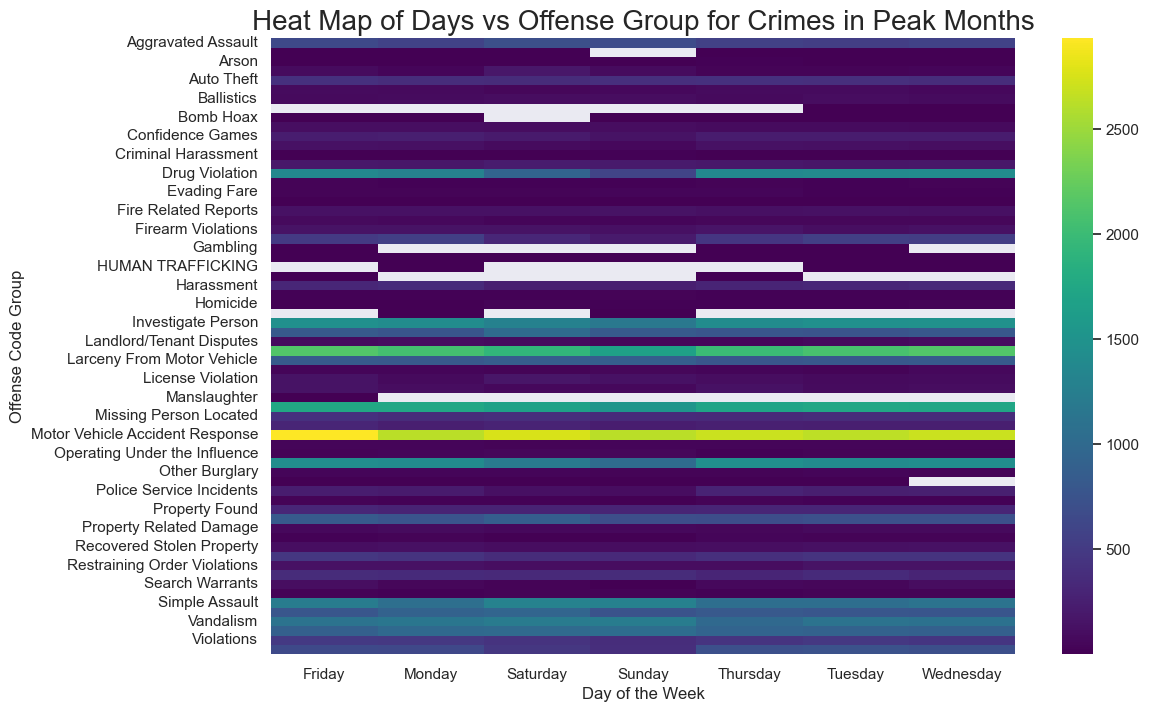

In [39]:
# heat map of days vs offense group for peak month crimes
heatmap_maker(data = peak_crime, index = 'OFFENSE_CODE_GROUP', columns = 'DAY_OF_WEEK', 
                xlabel='Day of the Week', ylabel='Offense Code Group', title = 'Heat Map of Days vs Offense Group for Crimes in Peak Months')

<img src='./images/week_offense_crime.png' style='width:700px;height:500px;'>

### Offense Against Child/Family seems to be very high weekly during these months. These months are active holiday months so this might be a reason
### Lets explore the overall proportion of offense group crimes

In [ ]:
#creating temporary dataframe and looking at vcounts
tmp = crime.dropna(subset=['OFFENSE_CODE_GROUP'])
tmp['OFFENSE_CODE_GROUP'].value_counts()

# made manually to deal with square plot not labels fitting properly (not an eloquent solution)
crime_sorted_freq = ['Vehicle Accident', 'Larceny', 'Medical', 'Investigate Person', 'Other', 'Drug Violation', 'Assault', 'Vandalism', 'Verbal Disputes', 'Investigate Property' ,     
'Towed', 'Larceny From Vehicle', 'Property Lost', 'Warrant Arrests',  'Aggravated Assault' , 'Fraud' ,'Violations',  'MP Located', 'Res Burglary', 'Auto Theft', 
'Robbery' ,  'Harassment', 'Property Found' ,'Missing Person' , 'Police Incidents', 'Conf Games ', 'Disorder Cond', 'Fire Reports','Firearm Viol', 'Lic. Viol.', 
'ROV', 'CF','RSP', 'CB', 'LV', 'ATR', 'B', 'LTD', 'SW', 'PRD', 'AGV', 'FD','LPRI' ,'OUI', 'OCF', 'OB', 'EF', 'E',  'S', 'PRI', 'HRI', 'H', '',  '', '', '' , 
'',  '', '', '', '', '', '', '' , '', '', '']          

In [ ]:
# create a color palette, mapped to these values
cmap = viridis
mini=min(tmp['OFFENSE_CODE_GROUP'].value_counts())
maxi=max(tmp['OFFENSE_CODE_GROUP'].value_counts())
norm = Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in tmp['OFFENSE_CODE_GROUP'].value_counts()]
 
# square plot with color mapping 
plt.figure(figsize=(18,10))
ax = squarify.plot(sizes=tmp['OFFENSE_CODE_GROUP'].value_counts(), label=crime_sorted_freq, alpha=0.85, color=colors, text_kwargs={'fontsize':11.5})
plt.title('Treemap of Offense Code Groups', fontsize=20)
plt.axis('off')
ax.invert_xaxis()
plt.show()

<img src='./images/treemap.png' style='width:1000px;height:600px;'>

### In overall proportions, Abuse Againt Child/Family is not in the top crimes meaning most of the Abuse Againt Child/Family crimes are committed during the peak months

### Lets explore a little more of the top 5 crimes in comparision to the overall crimes

In [ ]:
# temporary dataset with no na offense group values
tmp = crime.dropna(subset=['OFFENSE_CODE_GROUP'])

# count most offense group values and display the head
print(tmp['OFFENSE_CODE_GROUP'].value_counts().head())

# dataset for the 5 crimes which occur the most in the dataset
top_5_crime = tmp[(tmp['OFFENSE_CODE_GROUP'] == 'Motor Vehicle Accident Response') 
                        | (tmp['OFFENSE_CODE_GROUP'] == 'Larceny')
                        | (tmp['OFFENSE_CODE_GROUP'] == 'Medical Assistance')
                        | (tmp['OFFENSE_CODE_GROUP'] == 'Investigate Person')
                        | (tmp['OFFENSE_CODE_GROUP'] == 'Other')]

|               |  |
| ------------------- | ----------- |
|Motor Vehicle Accident Response   | 49603|
|Larceny                           | 34750|
|Medical Assistance                | 32741|
|Investigate Person                | 24754|
|Other                             | 24050|
|Name: OFFENSE_CODE_GROUP, dtype: int64| |

In [ ]:
# create data
tmp = top_5_crime.dropna(subset=['DISTRICT'])
district_names = list(tmp['DISTRICT'].unique())

# make white circle
my_circle = plt.Circle( (0,0), 0.8, color='white')

# put real data on circle
plt.pie(top_5_crime['DISTRICT'].value_counts(), labels=district_names)
pie = plt.gcf()
pie.gca().add_artist(my_circle)
plt.title('Circle plot of Districts for Top 5 Crimes data', fontsize=20)
plt.show()

<img src='./images/donut.png' style='width:600px;height:600px;'>

In [ ]:
# count plot of district crimes with hue of offense group with top 5 crimes
sns.countplot(data= top_5_crime, x='DISTRICT', hue='OFFENSE_CODE_GROUP')
plt.xlabel('Districts')
plt.title('District Crime Count Plot', fontsize=20)

<img src='./images/countplot.png' style='width:800px;height:500px;'>

In [ ]:
top_5_crime_districts = top_5_crime[top_5_crime['DISTRICT'] != 'External']
top_5_crime_districts = top_5_crime_districts['DISTRICT'].value_counts()

In [ ]:
# mapping and plotting district crime data with top 5 crime data
police_districts['top_crimes'] = police_districts.DISTRICT.map(top_5_crime_districts) # use map function to match each district with its corresponding value
ax = police_districts.plot(column = police_districts.top_crimes, cmap = 'viridis', legend = True, edgecolor = 'black', figsize = (12,8))

# put labels in districts
for x, y, label in zip(labels.geometry.x, labels.geometry.y, labels['DISTRICT']):
    plt.text(x, y, label, fontsize = 10, fontweight = 'bold', c = 'white')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 5 Crimes Per District in Boston', fontsize = 20)

<img src='./images/choropleth_top.png' style='width:700px;height:500px;'>

### Choropleth seems to be the same as before 

In [ ]:
# heat map of districts vs offense group for top 5 crimes
heatmap_maker(data = top_5_crime, index = 'OFFENSE_CODE_GROUP', columns = 'DISTRICT',
                xlabel='Districts', ylabel='Offense Code Groups', title = 'Heat Map of Districts vs Offense Code Groups for Top 5 Crimes')

<img src='./images/district_offense_top.png' style='width:700px;height:500px;'>

### Seems most of the Vehicle Accidents and Larceny are from specific districts

In [ ]:
# created datetime column from occured date for top 5 crimes
top_5_crime['OCCURRED_ON_DATE'] = pd.to_datetime(top_5_crime['OCCURRED_ON_DATE'])
top_5_crime['Date'] = top_5_crime['OCCURRED_ON_DATE'].dt.date
top_5_crime_date_df = top_5_crime['Date'].value_counts().to_frame()
top_5_crime_date_df.reset_index(inplace=True)
top_5_crime_date_df = top_5_crime_date_df.rename(columns = {'index':'Date', 'Date':'Count'})
top_5_crime_date_df  = top_5_crime_date_df.sort_values(by='Date')

In [ ]:
# creating axis with datetime and then plot time series for top 5 crimes
fig, ax = plt.subplots(figsize=(14, 8))
half_year_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(half_year_locator)
year_month_formatter = mdates.DateFormatter('%Y-%m') 
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(crime_date_df['Date'],crime_date_df['Count'])

# rotate/align x axis and label axes
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Top 5 Crimes Commited per Day')
plt.title('Timeseries of Top 5 Crimes a Day from 2015-2020', fontsize=20)

<img src='./images/timeseries_top.png' style='width:900px;height:500px;'>

### Timeseries analysis of top 5 crimes looks like overall crimes timeseries

### Lets look into the crimes that are not in the top 5 crimes

In [ ]:
# created dataframe without top 5 crimes
not_top_crime = crime[(crime['OFFENSE_CODE_GROUP'] != 'Motor Vehicle Accident Response')
                        & (crime['OFFENSE_CODE_GROUP'] != 'Larceny')
                        & (crime['OFFENSE_CODE_GROUP'] != 'Medical Assistance')
                        & (crime['OFFENSE_CODE_GROUP'] != 'Investigate Person')
                        & (crime['OFFENSE_CODE_GROUP'] != 'Other')]


In [ ]:
# created datetime column from occured date for not top 5 crimes
not_top_crime['OCCURRED_ON_DATE'] = pd.to_datetime(not_top_crime['OCCURRED_ON_DATE'])
not_top_crime['Date'] = not_top_crime['OCCURRED_ON_DATE'].dt.date
not_top_crime = not_top_crime['Date'].value_counts().to_frame()
not_top_crime.reset_index(inplace=True)
not_top_crime = not_top_crime.rename(columns = {'index':'Date', 'Date':'Count'})
not_top_crime = not_top_crime.sort_values(by='Date')

In [ ]:
# creating axis with datetime and then plot time series for not top 5 crimes
fig, ax = plt.subplots(figsize=(14, 8))
half_year_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(half_year_locator)
year_month_formatter = mdates.DateFormatter('%Y-%m') 
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(not_top_crime['Date'],not_top_crime['Count'])

# rotate/align x axis and label axes
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Crimes Commited per Day Not Including Top 5 Crimes')
plt.title('Timeseries of Crimes a Day Not Including Top 5 Crimes from 2015-2020', fontsize=20)

<img src='./images/timeseries_not_top.png' style='width:900px;height:500px;'>

### Interestingly there is a large increase of these lower occured crimes after the start of the pandemic which opposes the top 5 crimes which saw a decrease at the start of the pandemic